In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 9.5MB 14.7MB/s 
     |████████████████████████████████| 2.1MB 38.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [3]:
# Import required packages, libraries and classes for the project
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import datetime as dt
import time
from statsmodels.tsa.arima_model import ARIMAResults
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockQFLS.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,18.357,18.434,18.136,931720.0,18.078095,18.172928,0.552,48.683736,-0.697586,-0.060299,18.06710,-1.514221e+06,62.222222,57.805213,18.221
2014-06-16,18.145,18.179,17.898,982840.0,18.084190,18.168121,0.314,45.079524,-1.895735,-0.072873,18.07095,-1.509559e+06,44.773663,62.716049,18.009
2014-06-17,17.847,18.417,17.847,1220000.0,18.100762,18.184033,0.204,49.158841,-1.333765,-0.066277,18.08795,-1.619076e+06,66.419753,72.522678,18.272
2014-06-18,18.272,18.680,18.264,668690.0,18.112524,18.175237,0.094,51.311048,-1.541096,-0.083672,18.09220,-1.904605e+06,76.954733,72.963405,18.400
2014-06-19,18.349,18.485,18.196,488820.0,18.126238,18.152760,0.068,48.757124,-0.322299,-0.117691,18.09815,-2.017427e+06,74.193548,64.516129,18.247


In [5]:
# Extracting the features for the SARIMAX model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.tail()

(1461, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-03,16.08,0.12,35.200691,-5.633803,-0.108662,16.1715,-9.288576e+05,51.428571
2020-05-04,15.98,0.02,28.916703,-6.000000,-0.120386,16.2225,-1.136896e+06,22.857143
2020-05-05,16.02,0.02,30.025961,-5.150977,-0.124614,16.2755,-1.244356e+06,23.333333
2020-05-06,15.96,-0.01,25.969014,-6.062390,-0.131741,16.3245,-1.320832e+06,1.250000
2020-05-07,15.95,-0.05,25.281391,-5.228758,-0.133605,16.3710,-1.280957e+06,0.000000


In [6]:
# Make actual column contain the next day close value to be predicted 
steps=-1
dataset_with_step= series.copy()
dataset_with_step['Actual']=dataset_with_step['Close'].shift(steps)
dataset_with_step.dropna(inplace=True)
dataset_with_step.tail(3)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,Actual
Date,,,,,,,,,
2020-05-04,15.98,0.02,28.916703,-6.000000,-0.120386,16.2225,-1.136896e+06,22.857143,16.02
2020-05-05,16.02,0.02,30.025961,-5.150977,-0.124614,16.2755,-1.244356e+06,23.333333,15.96
2020-05-06,15.96,-0.01,25.969014,-6.062390,-0.131741,16.3245,-1.320832e+06,1.250000,15.95


In [7]:
# normalizing input features
from sklearn.preprocessing import StandardScaler
sc_in = StandardScaler()
scaled_input = sc_in.fit_transform(dataset_with_step[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [8]:
# normalizing output features
sc_out = StandardScaler()
scaler_output = sc_out.fit_transform(dataset_with_step[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [9]:
#Ceeate a dataframe to work with it after scaling 
X.rename(columns={0:'Close', 1:'MOM', 2:'RSI', 3:'ROC', 4:'MACD', 5:'BB', 6:'CHAIKIN',7:"STOCH"}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_with_step.index
X.tail(2)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-05,0.128319,0.007270,-1.717680,-0.745350,-0.472887,0.203459,-0.623276,-0.983402
2020-05-06,0.111902,-0.033467,-2.054107,-0.867316,-0.498131,0.216981,-0.678561,-1.698420


In [10]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_with_step.index
y.tail(2)

,Stock Price next day
Date,
2020-05-05,0.112347
2020-05-06,0.109611


In [11]:
# Train Val Test Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

print(X_train.shape,X_test.shape)

(1412, 8) (48, 8)


In [12]:
#Find the east parameters and model to fit the data 
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                     exogenous= X_train,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4468.259, Time=5.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4470.506, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4470.012, Time=3.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4475.834, Time=5.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4472.475, Time=1.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4471.425, Time=6.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4470.531, Time=6.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4478.051, Time=5.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4470.533, Time=5.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4474.892, Time=5.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4472.015, Time=3.52 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4472.889, Time=6.73 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 57.963 seconds


In [28]:
step_wise.summary()
# Show the best parameters for SARIMAX as (0, 1, 1) after a one-step shift for the actual feature

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1412
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2249.026
Date:                Mon, 04 Jan 2021   AIC                          -4478.051
Time:                        17:38:22   BIC                          -4425.531
Sample:                             0   HQIC                         -4458.425
                               - 1412                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Close         -0.8199      0.097     -8.444      0.000      -1.010      -0.630
MOM           -0.0094      0.003     -3.065      0.002      -0.015      -0.003
RSI           -0.0255      0.014     -1.860      0.063      -0.052       0.001
ROC           -0.0033      0.005     -0.657      0.511      -0.013       0.006
MACD           0.6621      0.030     21.815      0.000       0.603       0.722
BB             0.3812      0.135      2.829      0.005       0.117       0.645
CHAIKIN       -0.0052      0.002     -2.305      0.021      -0.010      -0.001
STOCH         -0.0058      0.004     -1.463      0.144      -0.014       0.002
ma.L1          0.5975      0.077      7.716      0.000       0.446       0.749
sigma2         0.0024   5.53e-05     43.727      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              1783.56
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.30
Prob(H) (two-sided):                  0.49   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

model= SARIMAX(y_train, 
           exog=X_train,
              order=(0,1,1),
              enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [30]:
results= model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [31]:
train_size = len(X_train)
test_size = len(X_test)

In [32]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [33]:
y_train_inv = sc_out.inverse_transform(y_train)
y_test_inv = sc_out.inverse_transform(y_test)
y_pred_inv = sc_out.inverse_transform(np.array([predictions]).T)

In [34]:
y_train_inv = pd.DataFrame(y_train_inv)
y_train_inv.reset_index(drop=True, inplace=True)
y_train_inv.index = y_train.index
y_train_inv.rename(columns={0	:'Stock Price next day'}, inplace=True)

In [35]:
predictions_df=pd.DataFrame(y_pred_inv)
predictions_df.reset_index(drop=True, inplace=True)
predictions_df.index=X_test.index
predictions_df['Actual'] = y_test_inv
predictions_df.rename(columns={0	:'Pred'}, inplace=True)

In [36]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index[:-1]
pred_date = df['2020-03-2' :].index[:-1]

In [37]:
import tensorflow as tf

In [38]:
pred = np.array([predictions]).T

In [39]:
mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_test, pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_test, pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_test, pred).numpy()

rmse = sqrt(mse)

In [40]:
print('MSE = {}'.format(round(mse, 4)))
print('RMSE = {}'.format(round(rmse, 4)))
print('MAPE = {}'.format(round(mape, 4)))
print('MAE = {}'.format(round(mae, 4)))

MSE = 0.109
RMSE = 0.3302
MAPE = 127.6177
MAE = 0.2987


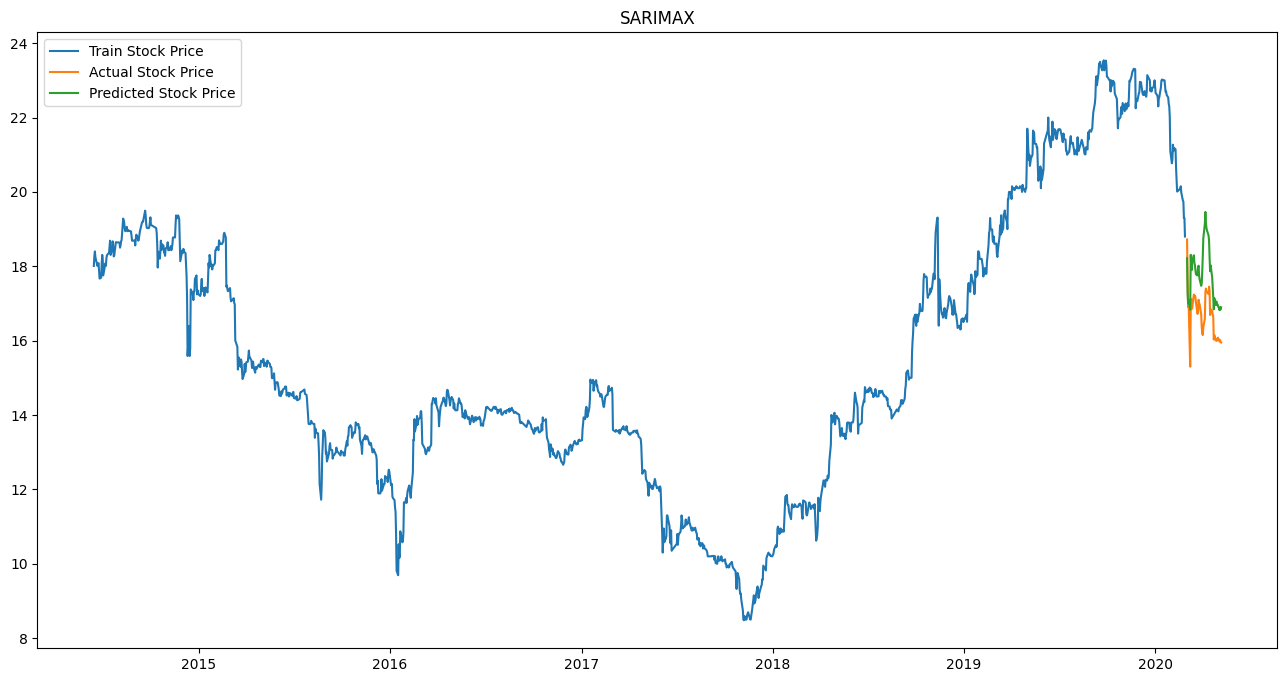

In [41]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = y_train_inv["Stock Price next day"]
price_close_test = predictions_df['Actual']
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, predictions_df['Pred'], label = "Predicted Stock Price")

plt.title("SARIMAX")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [42]:
results.save('model2.pkl')